<a href="https://colab.research.google.com/github/Sopralapanca/jet-brains-internship-challenge/blob/main/%5BJBI%5DImprovingWritingAssistance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

**Description**
Our team is currently developing a new platform that brings AI capabilities to all JetBrains products. Part of this platform is based on compact and efficient language models which help users write better text, no matter what JetBrains product they are using. We are looking for an ML Engineer who can contribute to our grammar error correction service within our writing assistance project. There are several open ideas which we would potentially like to explore:

* Fine-tuning large language models for the grammar error correction tasks
* Experimenting with ensembling and ranking of single-model systems
* Adapting recent advances in text-editing to grammar error correction
* Augmenting and enhancing our datasets using LLMs or alternative methods

Of course, we also welcome your own ideas and the application of other research papers.

**Test task 2**
One of the most widespread applications of natural language processing is to correct erroneous texts, in particular incorrectly spelled words. ***Your goal is to explore the existing spell checking tools and evaluate them***.

We suggest the following steps for this test assignment:

* Collect the data for evaluation, e.g. you can use publicly available datasets, generate synthetic data, combine different approaches – it's up to you.
* Research and choose the metrics you want to use for evaluation.
* Explore the existing spell checkers (e.g. libraries, fine-tuned models, LLMs), pick some you like and evaluate them on the created test set.
* Analyse the results and think about the strengths and weaknesses of each spell checker, as well as the reasons for that. Think about how they could be improved.

As a result, you should provide a link to a repository containing the source code and documentation, e.g.:

* Scripts containing data preparation and evaluation
* Documentation describing datasets, tools and metrics you used
* A short report that describes your approach and ideas summarises the results and discusses the challenges you encountered
* Instructions on how to run and locally reproduce the results

# Setup

In [ ]:
%%capture
!pip install transformers==4.44.2 swifter==1.4.0 seaborn==0.13.1 nltk==3.8.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 9.3 MB/s eta 0:00:00
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16506 sha256=fe9e82c814ee390a5836d031647cbaafabd7c12f41d82894410df571b80cddc4
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter


In [31]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Prepare the dataset

In [ ]:
# links https://huggingface.co/datasets/jhu-clsp/jfleg
# https://www.kaggle.com/datasets/satishgunjal/grammar-correction/data
# https://www.kaggle.com/code/dariocioni/gec-with-transformers-from-scratch
# https://github.com/mhagiwara/github-typo-corpus?tab=readme-ov-file

In [ ]:
#!git clone https://github.com/Sopralapanca/jet-brains-internship-challenge

Cloning into 'jet-brains-internship-challenge'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 7 (delta 1), reused 6 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (7/7), 64.00 KiB | 1.21 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [7]:
import pandas as pd

splits = {'validation': 'data/validation-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df_valid = pd.read_parquet("hf://datasets/jhu-clsp/jfleg/" + splits["validation"])
df_test = pd.read_parquet("hf://datasets/jhu-clsp/jfleg/" + splits["test"])
df = pd.concat([df_valid, df_test])

#optionally add other senteces from other dataframes or generate sintetic data

In [8]:
df.head()

,sentence,corrections
0,So I think we can not live if old people could...,[So I think we would not be alive if our ances...
1,For not use car .,"[Not for use with a car . , Do not use in the ..."
2,Here was no promise of morning except that we ...,"[Here was no promise of morning , except that ..."
3,Thus even today sex is considered as the least...,"[Thus , even today , sex is considered as the ..."
4,image you salf you are wark in factory just to...,[Imagine yourself you are working in factory j...


NOTE

una analisi potrebbe essere fatta su quali sono gli errori grammaticali più comuni? se abbreviazioni, capital case, errori nei verbi, typo ecc

In [10]:
len(df)

1503

In [13]:
df = df.explode("corrections")
len(df)

6012

In [14]:
df = df.drop_duplicates(subset=["sentence", "corrections"])
len(df)

4880

In [15]:
missing_values = df.isnull().sum()
missing_values

,0
sentence,0
corrections,0


In [16]:
df["sentence"] = df["sentence"].str.strip()
df["corrections"] = df["corrections"].str.strip()

In [18]:
df.head(10)

,sentence,corrections
0,So I think we can not live if old people could...,So I think we would not be alive if our ancest...
0,So I think we can not live if old people could...,So I think we could not live if older people d...
0,So I think we can not live if old people could...,So I think we can not live if old people could...
0,So I think we can not live if old people could...,So I think we can not live if old people can n...
1,For not use car .,Not for use with a car .
1,For not use car .,Do not use in the car .
1,For not use car .,Car not for use .
1,For not use car .,Can not use the car .
2,Here was no promise of morning except that we ...,"Here was no promise of morning , except that w..."
2,Here was no promise of morning except that we ...,"Here , there was no promise of morning , excep..."


In [19]:
df["sentence"] = df["sentence"].str.replace(r'^\d+\.\s+', '', regex=True)
df["corrections"] = df["corrections"].str.replace(r'^\d+\.\s+', '', regex=True)

In [20]:
df.head(10)

,sentence,corrections
0,So I think we can not live if old people could...,So I think we would not be alive if our ancest...
0,So I think we can not live if old people could...,So I think we could not live if older people d...
0,So I think we can not live if old people could...,So I think we can not live if old people could...
0,So I think we can not live if old people could...,So I think we can not live if old people can n...
1,For not use car .,Not for use with a car .
1,For not use car .,Do not use in the car .
1,For not use car .,Car not for use .
1,For not use car .,Can not use the car .
2,Here was no promise of morning except that we ...,"Here was no promise of morning , except that w..."
2,Here was no promise of morning except that we ...,"Here , there was no promise of morning , excep..."


# Data Analysis

In [22]:
import matplotlib.pyplot as plt

Visualization of the sentence lengths

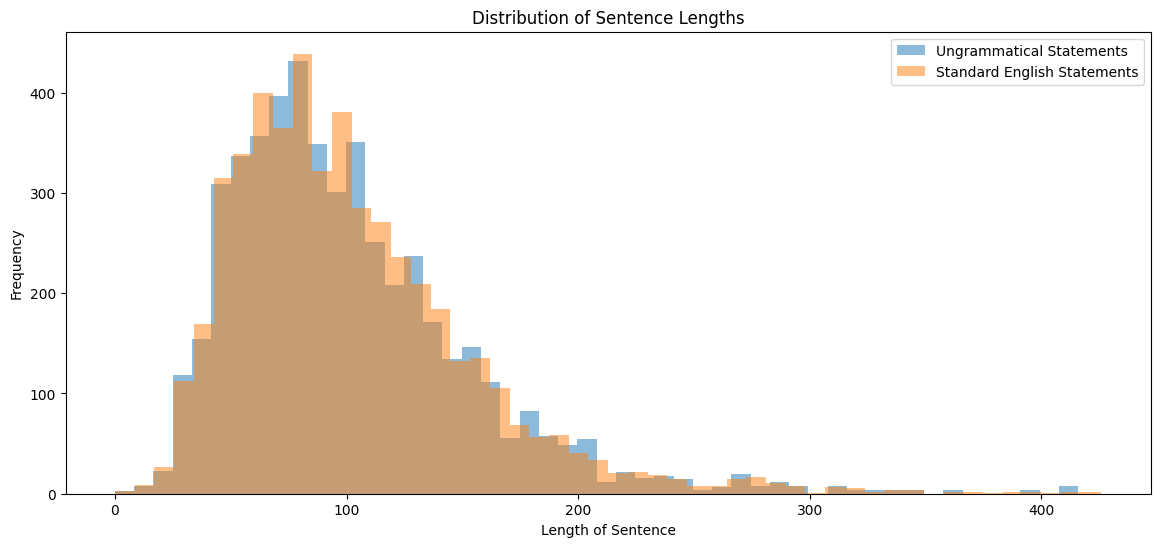

In [29]:
def plot_sentence_length_distribution(sentences: pd.Series, corrections: pd.Series):
  """
  Plot the distribution of sentence lengths for grammatical and non-grammatical sentences.
  param: sentences: pd.Series for ungrammatical sentences
  param: corrections: pd.Series for grammatical sentences
  """

  plt.figure(figsize=(14, 6))
  plt.hist(sentences.str.len(), bins=50, alpha=0.5, label='Ungrammatical Statements')
  plt.hist(corrections.str.len(), bins=50, alpha=0.5, label='Standard English Statements')
  plt.title('Distribution of Sentence Lengths')
  plt.xlabel('Length of Sentence')
  plt.ylabel('Frequency')
  plt.legend()

  plt.show()

plot_sentence_length_distribution(df["sentence"], df["corrections"])

Word Frequency Analysis

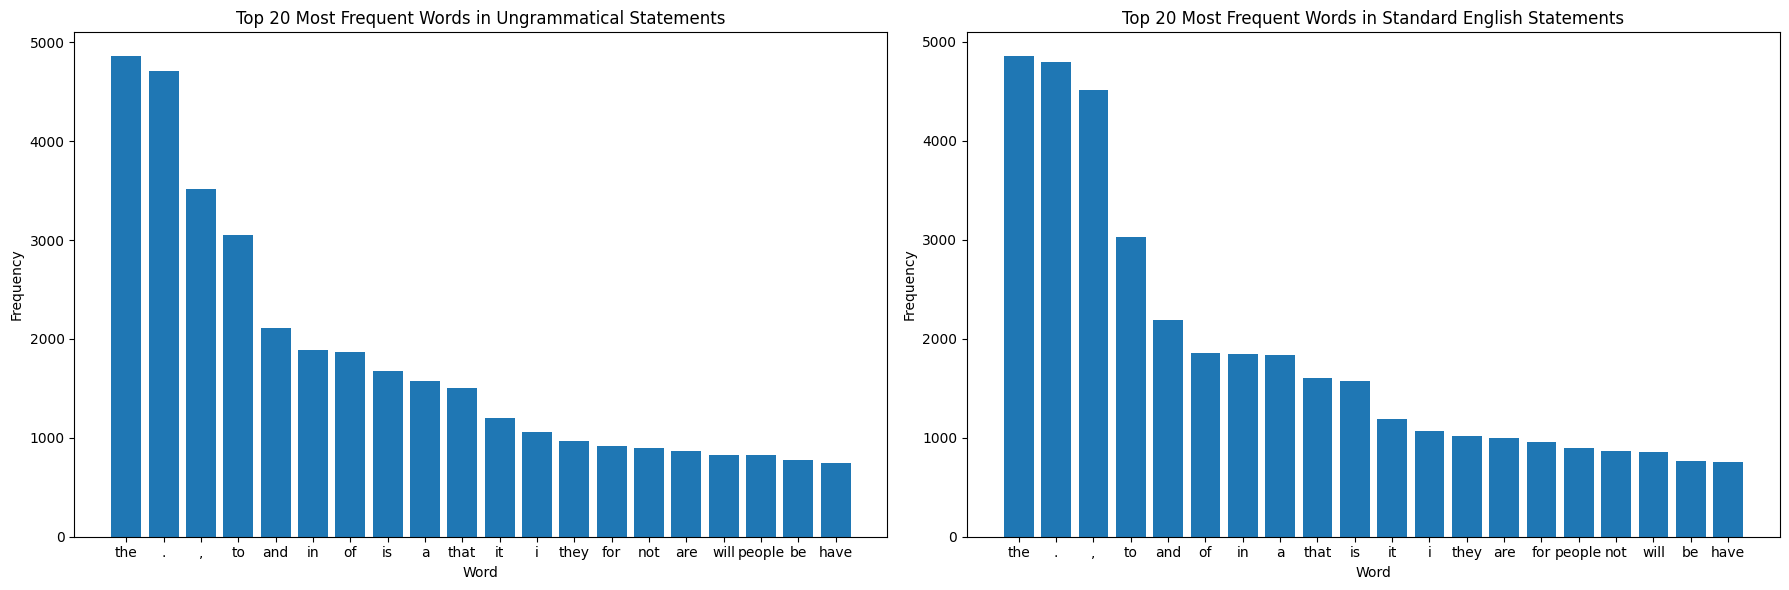

In [34]:
from collections import Counter
from nltk.tokenize import word_tokenize


def word_frequency(sentences: pd.Series, corrections: pd.Series):

    # Method to compute word frequency of a series of strings
    def compute_word_frequency(texts):
      words = []
      for text in texts:
        words.extend(word_tokenize(text.lower()))
      return Counter(words)

    # Compute word frequency for ungrammatical and grammatical sentences
    ungrammatical_word_freq = compute_word_frequency(sentences)
    grammatical_word_freq = compute_word_frequency(corrections)

    # plot the top 20 most frequent words side by side
    ungrammatical_word_freq_df = pd.DataFrame(ungrammatical_word_freq.most_common(20), columns=['Word', 'Frequency'])
    grammatical_word_freq_df = pd.DataFrame(grammatical_word_freq.most_common(20), columns=['Word', 'Frequency'])


    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.bar(ungrammatical_word_freq_df['Word'], ungrammatical_word_freq_df['Frequency'])
    plt.title('Top 20 Most Frequent Words in Ungrammatical Statements')
    plt.xlabel('Word')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.bar(grammatical_word_freq_df['Word'], grammatical_word_freq_df['Frequency'])
    plt.title('Top 20 Most Frequent Words in Standard English Statements')
    plt.xlabel('Word')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

word_frequency(df["sentence"], df["corrections"])


la virgola è molto meno frequente nel df con errori grammaticali. Molte persone sbagliano la virgola
La distribuzione di "in" e "of"cambia tra i due plot

POS tagging

In [35]:
from nltk import pos_tag

nltk.download('averaged_perceptron_tagger')




[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

<Figure size 3000x1000 with 0 Axes>

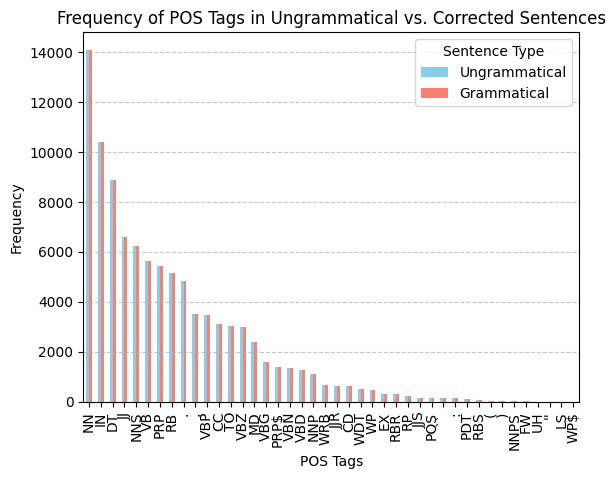

In [41]:
def pos_tag_distributions(sentences: pd.Series, corrections: pd.Series):

    # Method to compute pos tagging on a series of strings
    def pos_tagging(texts):
      tagged_sentences = []
      for sentence in sentences:
          tokens = word_tokenize(sentence)
          tagged = pos_tag(tokens)
          tagged_sentences.extend(tagged)
      return tagged_sentences

    # Compute pos tagging for ungrammatical and grammatical sentences
    pos_tag_ungrammatical = pos_tagging(sentences)
    pos_tag_grammatical = pos_tagging(corrections)

    # Count the frequency of each POS tag
    ungrammatical_pos_counts = pd.Series([tag for _, tag in pos_tag_ungrammatical]).value_counts()
    corrected_pos_counts = pd.Series([tag for _, tag in pos_tag_grammatical]).value_counts()

    # Convert to DataFrame for visualization
    pos_df = pd.DataFrame({
        'Ungrammatical': ungrammatical_pos_counts,
        'Grammatical': corrected_pos_counts
    }).fillna(0)

    # Plot
    plt.figure(figsize=(30, 10))
    pos_df.plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title('Frequency of POS Tags in Ungrammatical vs. Corrected Sentences')
    plt.xlabel('POS Tags')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)  # Rotate the labels vertically
    plt.legend(title='Sentence Type')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

pos_tag_distributions(df["sentence"], df["corrections"])

In [ ]:
# https://www.kaggle.com/code/satishgunjal/mining-mastering-the-art-of-english-corrections#Data-Cleaning

In [ ]:
%%time
import tqdm
import swifter
from transformers import T5Tokenizer, T5ForConditionalGeneration, pipeline

# Load the model and tokenizer (this example uses T5)
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base')


# Function to generate corrections using T5
def correct_sentence(sentence):
    # Prepare the input as "correct: <sentence>"
    input_text = "grammar: " + sentence  # Format for T5 grammar correction
    inputs = tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True)

    # Generate correction
    outputs = model.generate(inputs, max_length=512, num_beams=4, early_stopping=True)

    # Decode the generated tokens
    corrected_sentence = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return corrected_sentence

# Apply the model to each sentence and store the correction in a new column
df['t5_correction_sentence'] = df['sentence'].swifter.apply(correct_sentence)



spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Pandas Apply:   0%|          | 0/755 [00:00<?, ?it/s]

CPU times: user 20min 47s, sys: 6.67 s, total: 20min 54s
Wall time: 21min 25s


In [ ]:
# Display the DataFrame with original and corrected sentences
print(df[['sentence', 't5_correction_sentence']])

                                              sentence  \
0    So I think we can not live if old people could...   
1                                   For not use car .    
2    Here was no promise of morning except that we ...   
3    Thus even today sex is considered as the least...   
4    image you salf you are wark in factory just to...   
..                                                 ...   
750  The government also should try to reduce the s...   
751  Alot of memories with enogh time to remember w...   
752           Sceene of violence can affect on them .    
753  While the communities in general have reckoned...   
754                                                      

                    t5_correction_sentence  
0                                    False  
1                         For not use car.  
2                                    False  
3                                     True  
4                                    False  
..                               